# Statistical Algos

## Notebook's Environment

In [ ]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

## Cloud Environment Setup

In [ ]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

# Instruments

In [ ]:
from constants import *

INTERVAL = YFinanceOptions.M15
TARGET_FUT=WHEAT_FUT.replace("=F", "")

TARGET_FUT, INTERVAL

## Data Load

In [ ]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]
target_fut_df

In [ ]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

# Kalman Filter

A Kalman filter is used to estimate the values of variables cannot be measured directly. 

Estimating 2 error components in the predicted value $y_i$:
1. Mean-reverting error component ($\epsilon_{mr,t}$): This error corrects itself over time, meaning if it deviates from a certain value, it should return to that value. If not, the structure brokedown.
2. Random walk error component ($\epsilon_{rw,t}$): This error does not correct itself and continues in its last direction, with changes only due to random fluctuations.

$y_i$ is defined by:
- $C_0$ constant
- $X_i$ price at time T, and its coefficient $b$
- The systematic error $\epsilon_{s,t}$, and the errors: $\epsilon_{mr,t}$, $\epsilon_{rw,t}$.
- $\epsilon_t$ which is the spread between the $y_t$ observation and its prediction $\hat{y}$ based on x, consists of the error components listed above.

Error equations, have a zero mean noise component:
- $\epsilon_{mr,t}$ is a autoregressive + the noise $\epsilon_{mrs,t}$, with variance $\sigma^2_{mr}$
- $\epsilon_{rw,t}$ is a autoregressive + the noise $\epsilon_{rws,t}$, with variance $\sigma^2_{rw}$

Kalman is composed of: States, Observations, Transitions

$X_t = H_t Z_t + V_t$

$Z_t = F_{t-1} Z_{t-1} + G_{t-1} U_{t-1} + W_{t-1}$

- Zt is the unboservable state, mapped by Ht to Xt, and translates the internal hidden states.
- Xt is the price
- Ut is the control paramaters, 0 for this case. Gt linkes Ut to Zt, which is also 0.
- Ft-1 is the state change.
- Wt and Vt are the noise with their covar matrices Qt, Rt

The models equations:

- $P_t = F_{t-1} P_{t-1}^+ F_{t-1}^T + Q_{t-1}$
  - Predicts the new Error Covar Pt: acurracy of the next prediction.
  - Qt-1 is the noise covar. Ft-1 is the state transition.
  - Pt-1 is the previous covar, Qt is the noise covar for unreliability.
- $P_t^+ = (I - K_t H_t) P_t (I - K_t H_t)^T + K_t R_t K_t^T$
  - Update the error covar.
  - Pt+ is the new level of uncertaintity.
  - Kt is the kalman gain. Ht is he state, Rt is the noise covar, I is ID matrix.
- $K_t = P_t^- H_t^T (H_t P_t^- H_t^T + R_t)^{-1}$
  - The gain matrix that determines the prediction correctness.
  - Small gain == Xt is small, little uncertainty.
- $Z_t^- = F_{t-1} Z_{t-1}^+ + G_{t-1} U_{t-1}$
  - State update. From prev correct state Zt-t+, Ft-1 state transition and Gt-1 is the control input which is 0.
- $Z_t^+ = Z_t^- + K_t (X_t - H_t Z_t^-) = Z_t^-(1 - K_t H_t) + K_tX_t$
  - Updates to the corrected state Zt+ after the new data from Xt. Xt-HtZt is the residual.

state updates with b coeff $y_t = bx_t + \epsilon_{mr,t} + \epsilon_{rw,t}$:
$$
X_t = \begin{bmatrix} y_t \\ x_t \end{bmatrix} = \begin{bmatrix} b & 1 & 1 \\ 1 & 0 & 0 \end{bmatrix}  \begin{bmatrix} x_t \\ \epsilon_{mr,t} \\ \epsilon_{rw,t} \end{bmatrix}
$$

Residual updates, p -1..1 is the mean reversion:

$$
Z_t = \begin{bmatrix} x_t \\ \epsilon_{mr,t} \\ \epsilon_{rw,t} \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ \epsilon_{mr,t-1} \\ \epsilon_{rw,t-1} \end{bmatrix} + \begin{bmatrix} \epsilon_{xs,t} \\ \epsilon_{mrs,t} \\ \epsilon_{rws,t} \end{bmatrix}
$$ 

Assume MR and RW are indepent.

Var proportion to MR:
$$
R^2_{mr} = \frac{2\sigma^2_{mr}}{2\sigma^2_{mr} + (1 + \rho)\sigma^2_{rw}}
$$

Solving for p (mean reverting coeff - speed of adjustment) based on empyrical data:
$$
\rho = \frac{v_1 - 2v_2 + v_3}{2v_1 - v_2}
$$
Solving for MR std:
$$
\sigma^2_{mr} = \frac{1}{2}\left(\frac{\rho + 1}{\rho-1}\right)\left({v_2-2v_1}\right)
$$

$$
\sigma^2_{rw} = \frac{1}{2} \left( v_2 - 2 \sigma^2_{mr} \right)
$$

where k is:
$$
v_k = \frac{(\rho^k - 1)^2 + (1 - \rho^{2k})}{1 - \rho^2} \sigma_{mr}^2 + k \sigma_{rw}^2
$$

2v1-v2 = 0 is satisfied when ρ = 1, and as ρ < 1,

The gain matrix therefore is the influence of MR scaled to RW (K1) and the RW influence (K2):

$$
K = \begin{bmatrix} \frac{2\sigma_{mr}}{\sigma_{rw}\left(\sqrt{(\rho+1)^2\sigma_{rw}^2+4\sigma_{mr}^2+\rho\sigma_{rw}+\sigma_{rw}}+2\sigma_{mr}\right)}\\ \frac{2\sigma_{rw}}{{\sqrt{(\rho+1)^2\sigma_{rw}^2+4\sigma_{mr}^2-\rho\sigma_{rw}+\sigma_{rw}}}} \end{bmatrix} 
$$

When P is high, there is more MR component.

- Computational complexity is cubic in the size of the state space
- Parameter optimization is non-convex and can thus only find local optima
- Inability to cope with non-Gaussian noise



## B%

- %B is below 0 when price is below the lower band
- %B equals 0 when price is at the lower band
- %B is between 0 and .50 when price is between the lower and middle band (20-day SMA)
- %B is between .50 and 1 when price is between the upper and middle band (20-day SMA)
- %B equals 1 when price is at the upper band
- %B is above 1 when price is above the upper band

In [ ]:
from pykalman import KalmanFilter
from signals import signal_bollinger_bands
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools
import numpy as np

def calculate_variances(spread):
    # From the paper, they say V is lagged differences for partial coint.
    spread_diff = np.diff(spread, prepend=spread[0])
    spread_diff_lag1 = np.roll(spread_diff, 1)[1:]
    spread_diff_lag2 = np.roll(spread_diff, 2)[2:]

    v1 = np.var(spread_diff)
    v2 = np.var(spread_diff_lag1)
    v3 = np.var(spread_diff_lag2)

    return v1, v2, v3

def estimate_parameters(spread):
    v1, v2, v3 = calculate_variances(spread)

    # formulas provided by the paper
    rho = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    if v2 - 2*v1 >= 0:
        sigma_mr = np.sqrt(((v2 - 2*v1) * (1 + rho)) / (2 * (1 - rho)))
    else:
        # This happens when its not MR.
        sigma_mr = 1e-10
    sigma_rw = np.sqrt((v2 - 2*sigma_mr**2) / 2)

    return rho, sigma_mr, sigma_rw

def train_kf(spread, rho, sigma_mr, sigma_rw):
    beta = np.polyfit(spread, spread.shift(1).bfill(), 2)[0]
    x_init = np.array([beta, sigma_mr, sigma_rw])  # Initial state for [x_t, epsilon_mr_t, epsilon_rw_t]
    P_init = np.eye(3)  # Initial state covariance matrix

    # Transition matrix incorporating mean-reverting and random walk components
    F = np.array([[1, 0, 0],
                  [0, rho, 0],
                  [0, 0, 1]])

    # Observation matrix
    H = np.array([[1, 1, 1]])

    # Covariance matrices
    sigma_x = spread.var()
    Q = np.diag([sigma_x, sigma_mr, sigma_rw])
    R = np.array([[0.1]])

    kf = KalmanFilter(transition_matrices=F,
                     observation_matrices=H,
                     transition_covariance=Q,
                     observation_covariance=R,
                     initial_state_mean=x_init,
                     initial_state_covariance=P_init)
    kf = kf.em(spread, n_iter=50)

    return kf, x_init, P_init

def evaluate_kf(spread, rho, sigma_mr, sigma_rw, kf=None):
    if kf is None:
        kf, x, P = train_kf(spread, rho, sigma_mr, sigma_rw)
    else:
        x, P = kf.filter(spread)
        x = x[-1]
        P = P[-1]

    # Arrays to store the results
    predicted_spread = []
    predicted_uncertainty = []
    for t in tqdm(range(len(spread)), desc="evaluate_kf"):
        z = spread.iloc[t]
        x, P = kf.filter_update(filtered_state_mean=x, filtered_state_covariance=P, observation=z)

        predicted_spread.append(x[0])
        predicted_uncertainty.append(P[0, 0])

    return predicted_spread, kf

window = abs(HALF_LIFE)
bb_df = signal_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", window=window, std_factor=2.0)
spread = bb_df["%B"].bfill().ffill()

# Following the paper's estimations
p_rho, p_sigma_mr, p_sigma_rw = estimate_parameters(spread)
param_grid = {
    'rho': [p_rho],
    'sigma_mr': [p_sigma_mr],
    'sigma_rw': [p_sigma_rw],
}

tscv = TimeSeriesSplit(n_splits=2)
best_score = float('inf')
best_params = None

# Grid Search with Cross-Validation
param_combinations = list(itertools.product(param_grid['rho'], param_grid['sigma_mr'], param_grid['sigma_rw']))
for params in tqdm(param_combinations, total=len(param_combinations), desc="Grid Search.."):
    rho, sigma_mr, sigma_rw = params
    scores = []
    for train_index, val_index in tscv.split(spread):
        train_spread, val_spread = spread.iloc[train_index], spread.iloc[val_index]
        _, kf = evaluate_kf(train_spread, rho, sigma_mr, sigma_rw)
        predicted_spread, _ = evaluate_kf(val_spread, rho, sigma_mr, sigma_rw, kf)
        score = mean_squared_error(val_spread.values, predicted_spread)
        scores.append(score)

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print(f"Best Params: {best_params}")
print(f"Best Score: {best_score}")

In [11]:
train_spread, val_spread = spread.iloc[:-window], spread.iloc[window:]
rho, sigma_mr, sigma_rw = best_params

kf, x, P = train_kf(train_spread, rho, sigma_mr, sigma_rw)

kalman_gains = []
mean_reversion_errors = []
random_walk_errors = []
predicted_spread = []
predicted_uncertainty = []

for t in tqdm(range(len(val_spread)), desc="Validation"):
    x, P = kf.filter([val_spread.iloc[t]])
    x = x[-1]
    P = P[-1]
    z = val_spread.iloc[t]

    # Kalman gain
    H = kf.observation_matrices
    R = kf.observation_covariance
    K = np.dot(P, H.T).dot(np.linalg.inv(np.dot(H, P).dot(H.T) + R))
    kalman_gains.append(K[1])

    # Update Step
    x, P = kf.filter_update(filtered_state_mean=x, filtered_state_covariance=P, observation=z)
    predicted_spread.append(x[0])
    predicted_uncertainty.append(P[0, 0])

    # MR and RW Components
    mean_reversion_error = x[1]
    random_walk_error = x[2]

    mean_reversion_errors.append(mean_reversion_error)
    random_walk_errors.append(random_walk_error)

mse = mean_squared_error(val_spread.values, predicted_spread)
print(f'MSE {mse}') # 0.09447625314969771

Validation: 100%|██████████| 3049/3049 [00:02<00:00, 1499.48it/s]

MSE 0.1289667416527243


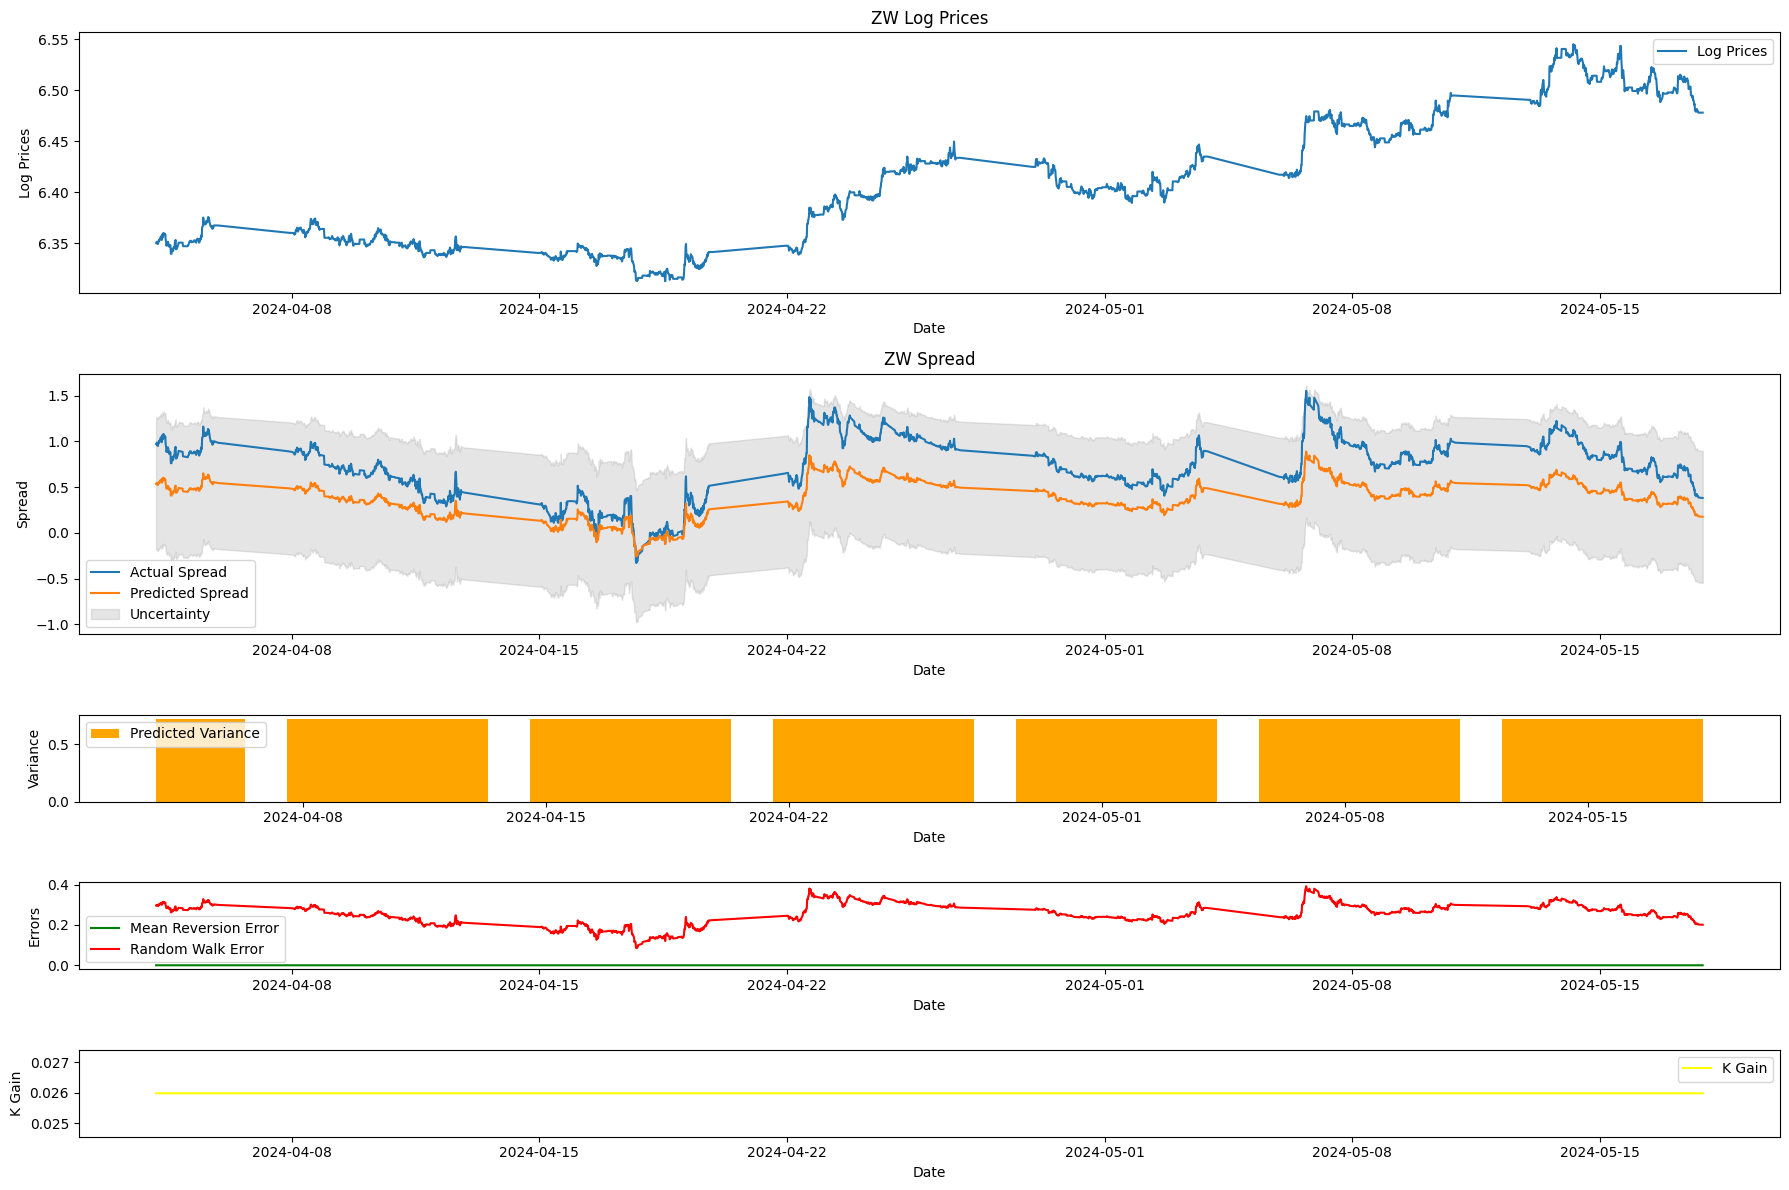

In [12]:
# Plotting the results
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [3, 3, 1, 1, 1]}, figsize=(18, 12))

# Log Prices
ax1.plot(futs_df[f'{TARGET_FUT}_Close'].index[window:], np.log(futs_df[f'{TARGET_FUT}_Close'].iloc[window:]), label='Log Prices')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Prices')
ax1.set_title(f'{TARGET_FUT} Log Prices')

# Actual vs Predicted Spread
ax2.plot(spread.index[window:], spread[window:], label='Actual Spread')
ax2.plot(spread.index[window:], predicted_spread, label='Predicted Spread')
ax2.fill_between(spread.index[window:],
                 np.array(predicted_spread) - np.sqrt(np.array(predicted_uncertainty)),
                 np.array(predicted_spread) + np.sqrt(np.array(predicted_uncertainty)),
                 color='gray', alpha=0.2, label='Uncertainty')
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Spread')
ax2.set_title(f'{TARGET_FUT} Spread')

# Predicted Variance
ax3.bar(spread.index[window:], np.sqrt(predicted_uncertainty), label='Predicted Variance', color='orange')
ax3.set_xlabel('Date')
ax3.set_ylabel('Variance')
ax3.legend()

# Component
ax4.plot(spread.index[window:], mean_reversion_errors, label='Mean Reversion Error', color='green')
ax4.plot(spread.index[window:], random_walk_errors, label='Random Walk Error', color='red')
ax4.set_xlabel('Date')
ax4.set_ylabel('Errors')
ax4.legend()

# K Gain
ax5.plot(spread.index[window:], kalman_gains, label='K Gain', color='yellow')
ax5.set_xlabel('Date')
ax5.set_ylabel('K Gain')
ax5.legend()

plt.tight_layout()
plt.show()